In [1]:
# %pip install -q -U numpy scikit-learn tensorflow tensorflow-model-optimization keras-tuner


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.api.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.api.layers import Concatenate, Dense, Dropout, Embedding, Flatten, Input
from keras.api.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

In [3]:
base_path = "ml-20m"

# Load the dataset
ratings = pd.read_csv(f"{base_path}/ratings.csv", low_memory=True)
movies = pd.read_csv(f"{base_path}/movies.csv", low_memory=True)


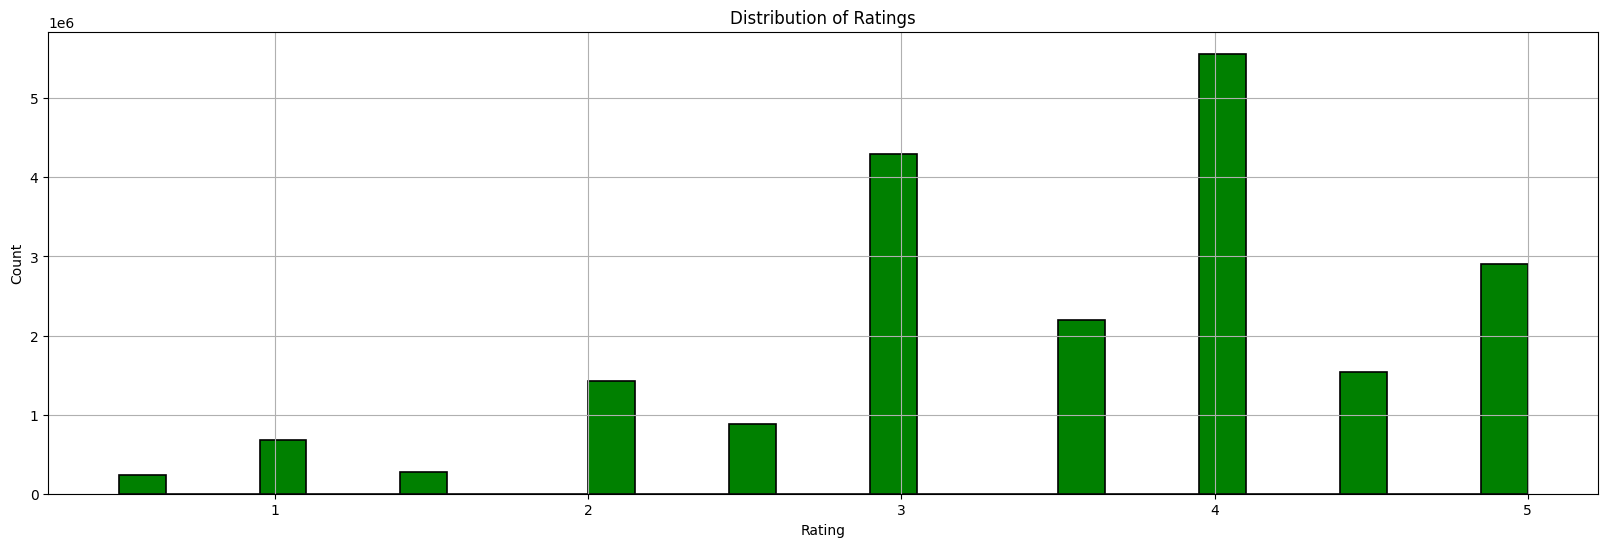

In [95]:
# @title Distribution of Ratings
plt.figure(figsize=(20, 6))
ratings["rating"].hist(bins=30, color="green", edgecolor="black", linewidth=1.2)
# Change color of the bars
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


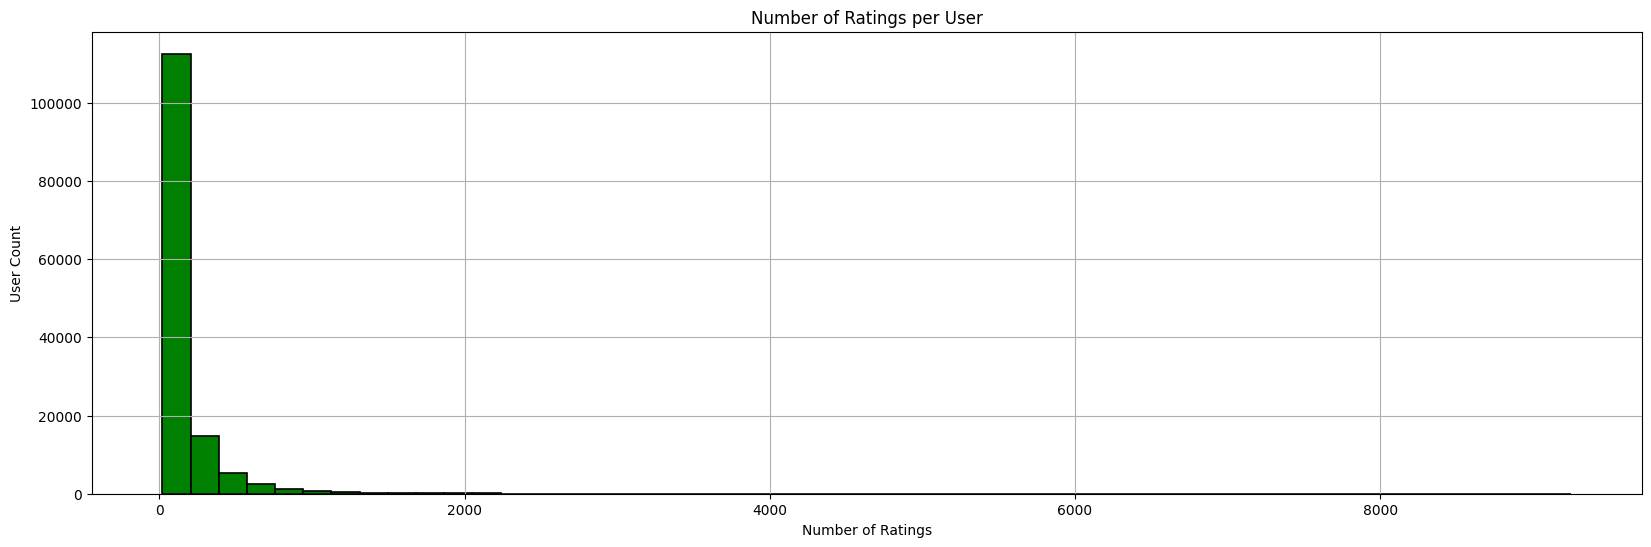

In [98]:
# @title Number of Ratings per User
plt.figure(figsize=(20, 6))
ratings.groupby("userId").count()["rating"].hist(bins=50, color="green", edgecolor="black", linewidth=1.2)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.show()


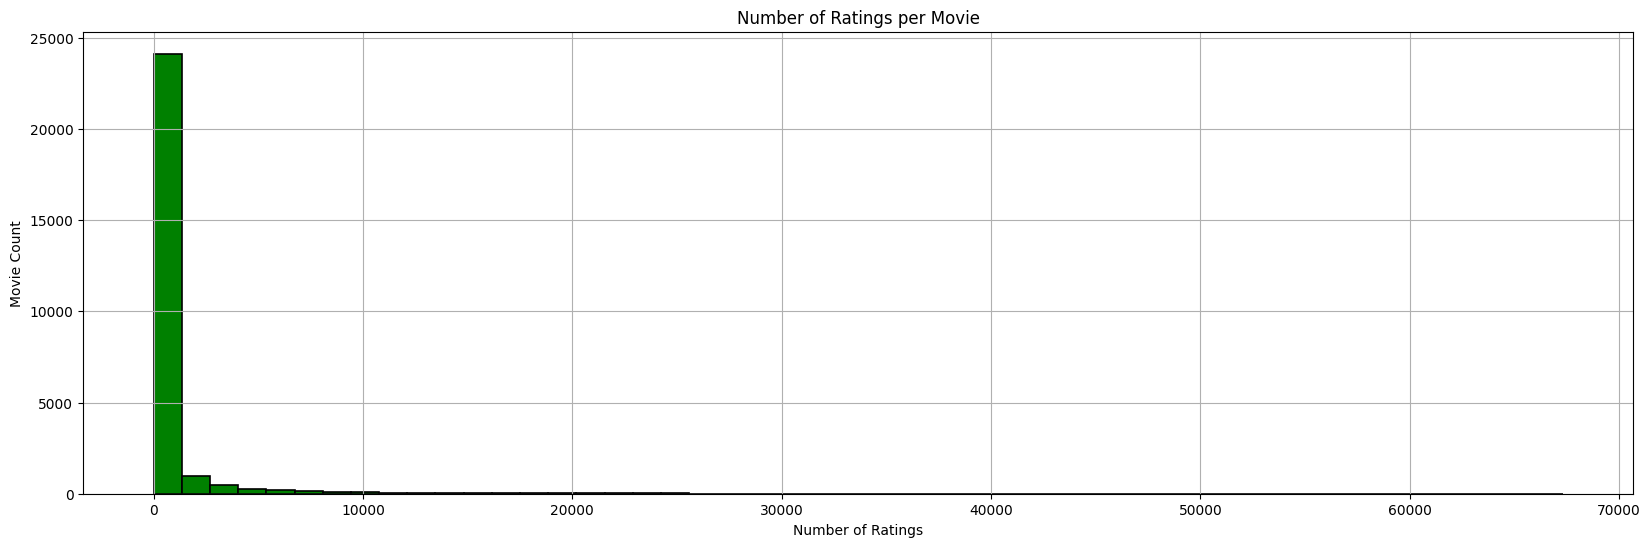

In [99]:
# @title Number of Ratings Per Movie
plt.figure(figsize=(20, 6))
ratings_per_movie = ratings.groupby("movieId").count()["rating"].hist(bins=50, color="green", edgecolor="black", linewidth=1.2)
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Count")
plt.show()


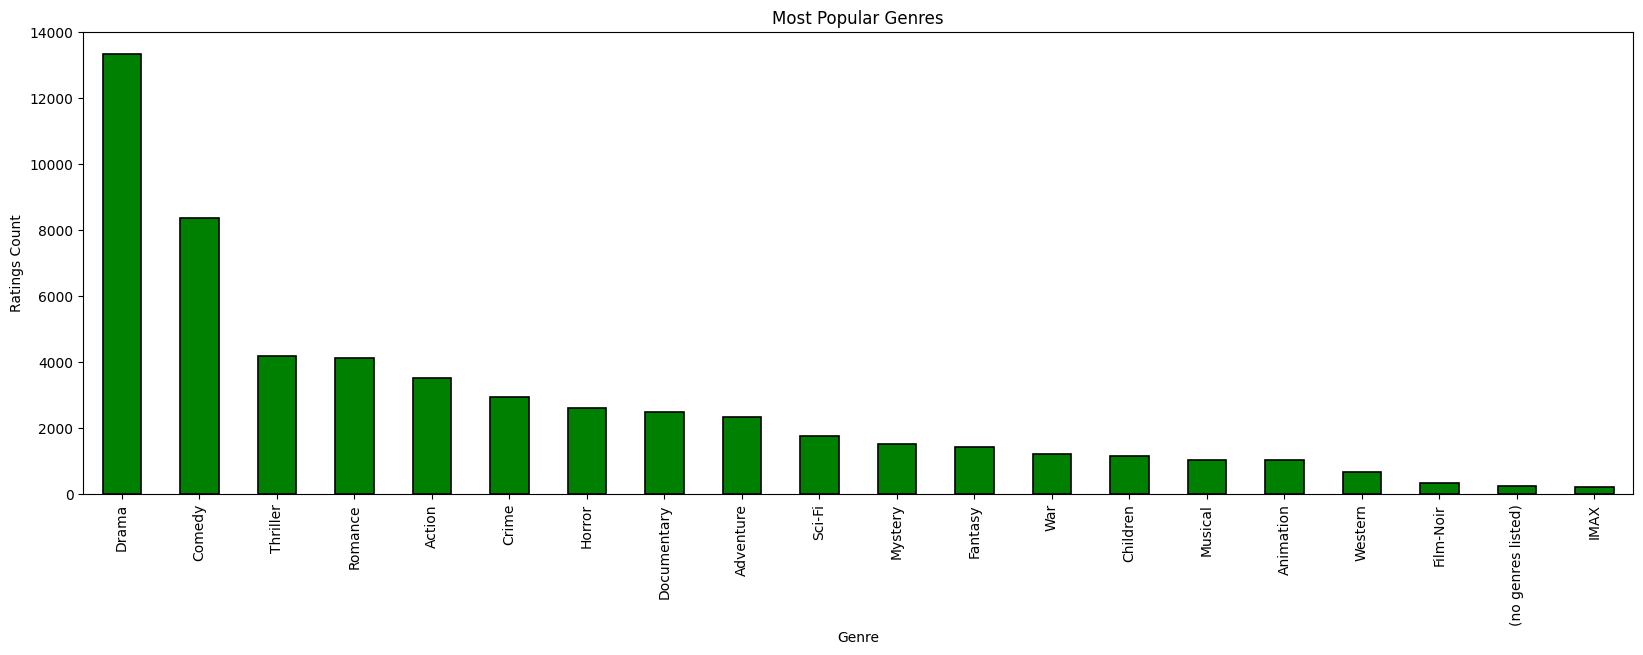

In [105]:
# @title Distribution of Movie Ratings
plt.figure(figsize=(20, 6))
genre_counts = movies["genres"].str.split("|").explode().value_counts()
genre_counts.plot(kind="bar", color="green", edgecolor="black", linewidth=1.2)
plt.title("Most Popular Genres")
plt.xlabel("Genre")
plt.ylabel("Ratings Count")
plt.show()


In [28]:
# @title Preprocess and split the dataset
# Merge datasets
data = pd.merge(ratings, movies, on="movieId")


# Use a smaller subset of the dataset
data = data.sample(n=200000, random_state=42)

# Encode userId and movieId
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

data["user"] = user_encoder.fit_transform(data["userId"])
data["movie"] = movie_encoder.fit_transform(data["movieId"])

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [29]:
data

,index,userId,movieId,rating,timestamp,title,genres,user,movie
0,158,1,7153,5.0,1112484633,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0,5041
1,459,5,141,5.0,851526935,"Birdcage, The (1996)",Comedy,1,122
2,521,6,52,5.0,858275658,Mighty Aphrodite (1995),Comedy|Drama|Romance,2,49
3,613,7,1272,4.0,1011205286,Patton (1970),Drama|War,3,1034
4,651,7,2080,4.0,1011206022,Lady and the Tramp (1955),Animation|Children|Comedy|Romance,3,1636
...,...,...,...,...,...,...,...,...,...
99995,19998599,138477,4848,4.0,1041189998,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,52109,3727
99996,19998663,138477,5952,4.0,1041400848,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,52109,4362
99997,19998590,138477,4447,3.5,1066397094,Legally Blonde (2001),Comedy|Romance,52109,3466
99998,19999136,138484,2,3.0,836154511,Jumanji (1995),Adventure|Children|Fantasy,52110,1


In [30]:
# @title Prepare training and test data
train_user = np.array(train_data["user"])
train_movie = np.array(train_data["movie"])
train_ratings = np.array(train_data["rating"])

test_user = np.array(test_data["user"])
test_movie = np.array(test_data["movie"])
test_ratings = np.array(test_data["rating"])


In [31]:
# @title Define data pipeline
def create_dataset(features, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset


train_dataset = create_dataset((train_user, train_movie), train_ratings)
test_dataset = create_dataset((test_user, test_movie), test_ratings)


# Neural Collaborative Filtering can be more complex and potentially more accurate.

In [50]:
# # Define NCF model
# import keras


# def create_ncf_model(num_users, num_movies, embedding_size=10):
#     user_input = Input(shape=(1,), name="user")
#     movie_input = Input(shape=(1,), name="movie")

#     user_embedding = Embedding(num_users, embedding_size)(user_input)
#     movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

#     user_flatten = Flatten()(user_embedding)
#     movie_flatten = Flatten()(movie_embedding)

#     concatenated = Concatenate()([user_flatten, movie_flatten])

#     dense = Dense(64, activation="relu")(concatenated)
#     dropout = Dropout(0.5)(dense)
#     output = Dense(1)(dropout)

#     model = Model(inputs=[user_input, movie_input], outputs=output)
#     return model


# num_users = len(user_encoder.classes_)
# num_movies = len(movie_encoder.classes_)

# # Using better optimizer
# optimizer = keras.optimizers.AdamW()

# # Create and compile model
# ncf_model = create_ncf_model(num_users, num_movies, embedding_size=20)
# ncf_model.compile(optimizer=optimizer, loss="mean_squared_error")

from keras.api.regularizers import l2

# Define NCF model with more layers and regularization
def create_ncf_model(num_users, num_movies, embedding_size=50, l2_reg=0.01):
    user_input = Input(shape=(1,), name="user")
    movie_input = Input(shape=(1,), name="movie")

    user_embedding = Embedding(num_users, embedding_size, embeddings_regularizer=l2(l2_reg))(user_input)
    movie_embedding = Embedding(num_movies, embedding_size, embeddings_regularizer=l2(l2_reg))(movie_input)

    user_flatten = Flatten()(user_embedding)
    movie_flatten = Flatten()(movie_embedding)

    concatenated = Concatenate()([user_flatten, movie_flatten])

    dense_1 = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(concatenated)
    dropout_1 = Dropout(0.5)(dense_1)
    dense_2 = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(dropout_1)
    dropout_2 = Dropout(0.5)(dense_2)
    output = Dense(1)(dropout_2)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    return model

In [51]:
# Hyperparameter tuning
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)

def build_model(hp):
    model = create_ncf_model(
        num_users,
        num_movies,
        embedding_size=hp.Int("embedding_size", min_value=20, max_value=100, step=10),
        l2_reg=hp.Float("l2_reg", min_value=0.001, max_value=0.1, sampling="log")
    )
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [56]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="my_dir",
    project_name="ncf_tuning"
)
epochs=25
tuner.search(
    train_dataset, epochs=epochs, validation_data=test_dataset
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 14m 14s]
val_loss: 1.1027573347091675

Best val_loss So Far: 1.0791212320327759
Total elapsed time: 05h 44m 30s


In [34]:
# %rm -rf /content/untitled_project/


In [58]:
from keras import mixed_precision

# Set mixed precision policy
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)


In [59]:
# Train the best model with early stopping and learning rate reduction
checkpoint = ModelCheckpoint("best_ncf_model.keras", save_best_only=True, monitor="val_loss", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2)

best_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping, reduce_lr],
)

# Evaluate the model
ncf_loss = best_model.evaluate(test_dataset)
print("Best Model Loss: ", ncf_loss)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.1152
Epoch 1: val_loss improved from inf to 1.13106, saving model to best_ncf_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - loss: 1.1152 - val_loss: 1.1311 - learning_rate: 0.0010
Epoch 2/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1093
Epoch 2: val_loss improved from 1.13106 to 1.09752, saving model to best_ncf_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 1.1092 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 3/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.1260
Epoch 3: val_loss did not improve from 1.09752
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - loss: 1.1260 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 4/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.1349
Epoch 4: val_loss did not improve from 1.09752
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - loss: 1.1349 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 5/50
1249/1250 ━━━━━━━━━━━━━━━━━━━

In [60]:
import keras

# Display info about saved model using keras


saved_model_path = "best_ncf_model.keras"

# Load the saved model
loaded_model = keras.models.load_model(saved_model_path)

# Display model summary
loaded_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 60)     │  3,126,720 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 60)     │    507,960 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 60)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 60)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     15,488 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,975,473 (41.87 MB)

 Trainable params: 3,658,489 (13.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,316,984 (27.91 MB)

In [62]:
# Make predictions
def predict_ratings(user_ids, movie_ids):
    user_ids_encoded = user_encoder.transform(user_ids)
    movie_ids_encoded = movie_encoder.transform(movie_ids)

    predictions = loaded_model.predict([user_ids_encoded, movie_ids_encoded])
    return predictions


# Provide recommendations
def recommend_movies(user_id, top_n=10):
    # Encode user_id
    user_id_encoded = user_encoder.transform([user_id])

    # Get all movie ids
    all_movie_ids = movie_encoder.classes_
    movie_ids_encoded = np.arange(len(all_movie_ids))

    # Predict ratings
    predictions = predict_ratings([user_id] * len(all_movie_ids), all_movie_ids)

    # Create a DataFrame with the movie ids and predicted ratings
    recommendations = pd.DataFrame(
        {"movieId": all_movie_ids, "predicted_rating": predictions.flatten()}
    )

    # Merge with movies DataFrame to get movie details
    recommendations = recommendations.merge(movies, on="movieId")

    # Get top N recommendations
    top_recommendations = recommendations.sort_values(
        by="predicted_rating", ascending=False
    ).head(top_n)

    return top_recommendations


In [69]:
# Example usage
user_id = 105623  # Replace with an actual userId from your dataset
top_recommendations = recommend_movies(user_id)
print(top_recommendations.to_markdown())


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
|      |   movieId |   predicted_rating | title                                                                       | genres                                          |
|-----:|----------:|-------------------:|:----------------------------------------------------------------------------|:------------------------------------------------|
|   48 |        50 |            4.49252 | Usual Suspects, The (1995)                                                  | Crime|Mystery|Thriller                          |
|  282 |       318 |            4.41597 | Shawshank Redemption, The (1994)                                            | Crime|Drama                                     |
| 6912 |     58559 |            4.39056 | Dark Knight, The (2008)                                                     | Action|Crime|Drama|IMAX                         |
|  985 |      1221 |            4.38862 | Godfather: Part II, The (1974)                                     